# Mini Project ---- Multiple Linear Regression (MLR)



#### Shan Xu


In [1]:
# open liberaries
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# function Mean Absolute Percentage Error
def mean_absolute_percentage_error(y,y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return 100*np.mean(np.abs((y-y_pred)/y))


### Data Analysis Before Modeling

In [2]:
# Read the datafile into a dataframe df.
file=pd.read_csv("sce.csv")
df=pd.DataFrame(file)
df['Date']=pd.to_datetime(df['Date'])
df[:5]

,Date,Load,temp
0,2014-01-01 00:00:00,9891.0,59.4685
1,2014-01-01 01:00:00,9553.0,61.4030
2,2014-01-01 02:00:00,9222.0,55.0310
3,2014-01-01 03:00:00,9024.0,53.1878
4,2014-01-01 04:00:00,8987.0,51.9944


In [3]:
# create columns for the year, month, day, hour, and day of week
df['year']=df['Date'].dt.year
df['month']=df['Date'].dt.month
df['day']=df['Date'].dt.day
df['hour']=df['Date'].dt.hour
df["dayofweek"] =df['Date'].dt.dayofweek

df.dtypes

Date         datetime64[ns]
Load                float64
temp                float64
year                  int64
month                 int64
day                   int64
hour                  int64
dayofweek             int64
dtype: object

In [4]:
df[-5:]

,Date,Load,temp,year,month,day,hour,dayofweek
49675,2019-09-01 19:00:00,17139.0,88.0080,2019,9,1,19,6
49676,2019-09-01 20:00:00,16516.0,89.1480,2019,9,1,20,6
49677,2019-09-01 21:00:00,15667.0,88.8970,2019,9,1,21,6
49678,2019-09-01 22:00:00,14515.0,89.1035,2019,9,1,22,6
49679,2019-09-01 23:00:00,13353.0,88.4475,2019,9,1,23,6


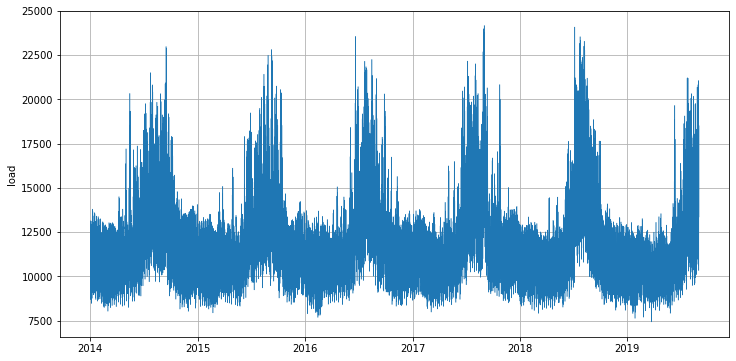

In [5]:
# Plot of Load as a function of time with the x-axis displaying the years.
plt.figure(figsize = (12,6))
plt.plot(df['Date'],df['Load'],label='Load',lw=0.5)
plt.ylabel('load')
plt.grid()

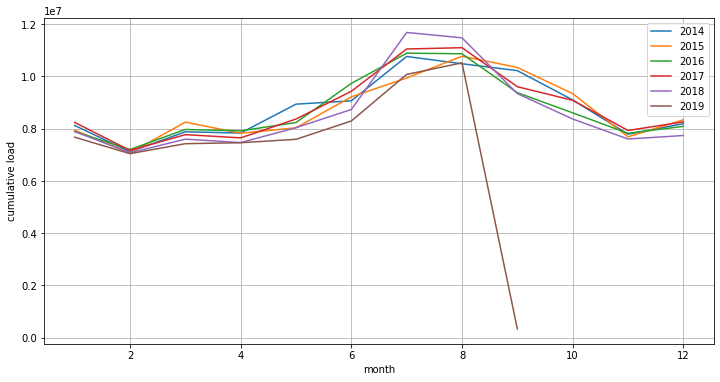

In [6]:
# Plot the cumulative load by year and month
# seasonal chart
df_p = df.copy()
df_p1 = df_p[['Load','year','month']]

plt.figure(figsize = (12,6))
plt.grid()

for i in pd.unique(df_p1.year):
    dk=df_p1[df_p1.year==i]
    dd=dk.pivot_table('Load',index = 'month',aggfunc = np.sum)
    plt.plot(figsize=(12,6),grid=True)
    plt.plot(dd.index,dd.Load,label = str(i))
    plt.xlabel("month")
    plt.ylabel("cumulative load")
    plt.legend()

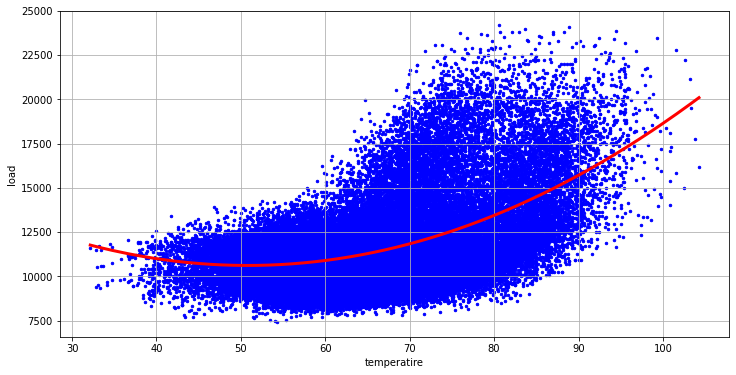

In [7]:
# Construct a scatterplot of Load vs temp with the x-axis displaying the years. 
# transform temp to square of temp; a good predictor of the Load in RL
df_p = df_p.sort_values('temp')
load = df_p.Load
temp = df_p.temp
temp_1 =temp.values.reshape(-1,1)
poly = PolynomialFeatures(degree=2)
temp_2 = poly.fit_transform(temp_1)

lr_model = LinearRegression().fit(temp_2,load)
yhat = lr_model.predict(temp_2)

plt.figure(figsize = (12,6))
plt.scatter(temp,load,c='b',s=6)
# Add a quadratic least squares (red) line on the plot. 
plt.plot(temp,yhat,c='r',lw=3)
plt.xlabel('temperatire')
plt.ylabel('load')
plt.grid()

### Mutliple Linear Regression Model

#### Model 1 (with all predictors)

In [8]:
# Fit a Mutliple regression model with all predictors
df1 = df.copy()
model1 = smf.ols("Load~temp+year+month+day+hour+dayofweek",data=df1).fit()

# cal for r-square and MAPE
m1_rsq = model1.rsquared
df1['Load_pred']=model1.predict(df1)
m1_mape=mean_absolute_percentage_error(df1['Load'],df1['Load_pred'])

print("The r-square is",round(m1_rsq,4), ". MAPE is ",  round(m1_mape,4))

The r-square is 0.4151 . MAPE is  11.7369


#### Model 2 (adding squared temperature)

In [9]:
# Adding squared temperature to muliple regression
# Check r-square and MAPE

df2=df.copy()
df2['temp_2'] = df2['temp']**2

model2 = smf.ols("Load~temp+temp_2+year+month+day+hour+dayofweek+temp*hour+temp_2*hour",data=df2).fit()
m2_rsq = model2.rsquared

df2['Load_pred']=model2.predict(df2)
m2_mape=mean_absolute_percentage_error(df2['Load'],df2['Load_pred'])

print("The r-square is",round(m2_rsq,4), ". MAPE is ",  round(m2_mape,4))

The r-square is 0.4325 . MAPE is  11.2811


#### Model 3 (additional lags for new predictors)

C:\Users\nian\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


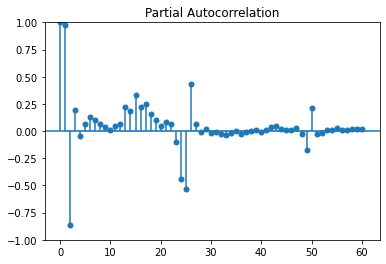

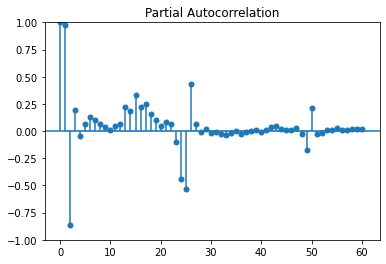

In [10]:
# plot partial autocorrelations
df3 = df2.copy()
sm.graphics.tsa.plot_pacf(df3.Load, lags = 60)

In [11]:
# by looking the figure above, I choose 15, 24, 25, 26, 50 as additional lags for new predictors
df3['lag24']=df3['Load'].shift(24)
df3['lag15']=df3['Load'].shift(15)
df3['lag25']=df3['Load'].shift(25)
df3['lag26']=df3['Load'].shift(26)
df3['lag50']=df3['Load'].shift(50)
MLR = smf.ols("Load~temp+temp_2+year+month+day+hour+dayofweek+temp*hour+temp_2*hour+lag24+lag15+lag25+lag26+lag50",data=df3[50:]).fit()
m3_rsq = MLR.rsquared
df3['Load_pred']=MLR.predict(df3)
m3_mape=mean_absolute_percentage_error(df3['Load'][50:],df3['Load_pred'][50:])
m3_mape

print("The r-square is",round(m3_rsq,4), ". MAPE is",round(m3_mape,4))

The r-square is 0.9175 . MAPE is 4.5483


In [12]:
df3

,Date,Load,temp,year,month,day,hour,dayofweek,temp_2,Load_pred,lag24,lag15,lag25,lag26,lag50
0,2014-01-01 00:00:00,9891.0,59.4685,2014,1,1,0,2,3536.502492,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01 01:00:00,9553.0,61.4030,2014,1,1,1,2,3770.328409,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-01 02:00:00,9222.0,55.0310,2014,1,1,2,2,3028.410961,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-01 03:00:00,9024.0,53.1878,2014,1,1,3,2,2828.942069,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-01 04:00:00,8987.0,51.9944,2014,1,1,4,2,2703.417631,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49675,2019-09-01 19:00:00,17139.0,88.0080,2019,9,1,19,6,7745.408064,16787.832918,17656.0,10364.0,18533.0,19035.0,20657.0
49676,2019-09-01 20:00:00,16516.0,89.1480,2019,9,1,20,6,7947.365904,16162.629745,16886.0,10358.0,17656.0,18533.0,19827.0
49677,2019-09-01 21:00:00,15667.0,88.8970,2019,9,1,21,6,7902.676609,15213.704477,15838.0,10325.0,16886.0,17656.0,18757.0
49678,2019-09-01 22:00:00,14515.0,89.1035,2019,9,1,22,6,7939.433712,14086.942581,14613.0,10415.0,15838.0,16886.0,17836.0


### Find the best model

In [13]:
# Split data into test (2019 load values) and trian (all others)

df4 = df3.copy()
df4 = df4[50:]
df4['temp_hour'] = df4['temp']*df['hour']
df4['temp2_hour'] = df4['temp_2']*df['hour']

test = df4[df4.year == 2019]
train = df4[df4.year != 2019]

test_y = test["Load"]
train_y = train["Load"]
test_x = test.drop(['Load','Date','Load_pred'],axis=1)
train_x = train.drop(['Load','Date','Load_pred'],axis=1)

In [14]:
test_x[:5]

,temp,year,month,day,hour,dayofweek,temp_2,lag24,lag15,lag25,lag26,lag50,temp_hour,temp2_hour
43824,57.92850,2019,1,1,0,1,3355.711112,9352.0,10426.0,9883.0,10573.0,10986.0,0.00000,0.000000
43825,57.03736,2019,1,1,1,1,3253.260436,8967.0,10382.0,9352.0,9883.0,10369.0,57.03736,3253.260436
43826,55.31236,2019,1,1,2,1,3059.457169,8755.0,10234.0,8967.0,9352.0,9819.0,110.62472,6118.914338
43827,52.90550,2019,1,1,3,1,2798.991930,8707.0,10040.0,8755.0,8967.0,9451.0,158.71650,8396.975791
43828,50.70200,2019,1,1,4,1,2570.692804,8881.0,9828.0,8707.0,8755.0,9239.0,202.80800,10282.771216


In [15]:
# bulid a function for cal SSE, R_Square, and MAPE
from sklearn.metrics import mean_squared_error

def get_sse(X,Y,x1,y1):
    model = LinearRegression().fit(X,Y)
    yhat = model.predict(x1)
    n=len(x1.index)
    SSE = mean_squared_error(y1,yhat)*n
    mape=mean_absolute_percentage_error(y1,yhat)
    R_squared = model.score(x1,y1)
    return SSE, R_squared, mape

In [16]:
p = len(test_x.columns)

In [17]:
p

14

In [18]:
import itertools
MAPE_list, SSE_list, R2_list, feature_list, num_features = [],[],[],[],[]

for k in range(1,p+1):
    for subset in itertools.combinations(test_x.columns,k):
        feature_list.append(subset)
        num_features.append(len(subset))
        X1 = train_x[list(subset)]
        X2 = test_x[list(subset)]
        SSE, R_squared, mape = get_sse(X1,train_y,X2,test_y)
        MAPE_list.append(mape)
        SSE_list.append(SSE)
        R2_list.append(R_squared)
        
zip1 = zip(num_features,feature_list,R2_list,SSE_list,MAPE_list)
dkk = pd.DataFrame(list(zip1),
                  columns = ['n_features','features','R-squared','SSE','MAPE'])

pd.set_option('display.max_colwidth',190)

In [19]:
best_r2 = dkk.groupby(['n_features'])['R-squared'].max()
best_r2

n_features
1     0.858764
2     0.906183
3     0.909052
4     0.911022
5     0.914139
6     0.916857
7     0.918732
8     0.919033
9     0.919086
10    0.919077
11    0.919034
12    0.918957
13    0.918866
14    0.918797
Name: R-squared, dtype: float64

In [20]:
dkk2 = pd.DataFrame()
mask = dkk['R-squared'].isin(best_r2[0:p+1])
dkk2 = pd.concat([dkk2, dkk[mask]])
dkk2


,n_features,features,R-squared,SSE,MAPE
7,1,"(lag24,)",0.858764,4.984939e+09,5.825796
70,2,"(dayofweek, lag24)",0.906183,3.311268e+09,4.785403
397,3,"(dayofweek, lag24, temp2_hour)",0.909052,3.210002e+09,4.748642
1346,4,"(dayofweek, temp_2, lag24, lag26)",0.911022,3.140477e+09,4.761872
2061,5,"(temp, dayofweek, temp_2, lag24, lag26)",0.914139,3.030471e+09,4.724942
4642,6,"(temp, dayofweek, temp_2, lag24, lag26, lag50)",0.916857,2.934524e+09,4.651340
8123,7,"(temp, dayofweek, temp_2, lag24, lag26, lag50, temp_hour)",0.918732,2.868370e+09,4.647290
10763,8,"(temp, year, dayofweek, temp_2, lag24, lag26, lag50, temp_hour)",0.919033,2.857730e+09,4.620542
13304,9,"(temp, year, month, dayofweek, temp_2, lag24, lag26, lag50, temp_hour)",0.919086,2.855862e+09,4.618107
15216,10,"(temp, year, month, dayofweek, temp_2, lag24, lag25, lag26, lag50, temp_hour)",0.919077,2.856180e+09,4.618850


In [21]:
# the best model is 
dkk[dkk['R-squared']==best_r2[9]]

,n_features,features,R-squared,SSE,MAPE
13304,9,"(temp, year, month, dayofweek, temp_2, lag24, lag26, lag50, temp_hour)",0.919086,2.855862e+09,4.618107
